# Локальный градиентный спуск

In [1]:
import numpy as np
from matplotlib import pyplot as plt

**Цель:** минимизировать значение функции $F(x) = \frac{1}{M}\sum \limits_{i = 1}^{M} f_i (x)$.  
**Описание алгоритма:** локальный градиентный спуск, реализованный в файле main.py, принимает на вход следующие аргументы:  
1) N - количество эпох, т.е. количество коммуникаций между сервером и клиентами  
2) H - количество шагов градиентного спуска в каждой эпохе (частота коммуникаций)  
3) $x_0$ - начальная точка  
4) $\gamma$ - коэффициент при градиентном шаге  
4) M градиентов  
  
Алгоритм возвращает все точки, отправленные клиентам за всё время его работы.  
  
Возьмем для начала в качестве функций $f_1(x), f_2(x), f_3(x)$ билинейные квадратичные формы, задаваемые матрицами:  
$A_1 = \quad \begin{pmatrix} 1 & 0 & 0 \\ 0 & 2 & 0 \\ 0 & 0 & 3 \end{pmatrix} \quad$ 
$A_2 = \quad \begin{pmatrix} 1 & 0 & 0 \\ 0 & 2 & 0 \\ 0 & 0 & 1 \end{pmatrix} \quad$ 
$A_3 = \quad \begin{pmatrix} 2 & 0 & 0 \\ 0 & 2 & 0 \\ 0 & 0 & 1 \end{pmatrix} \quad$

Заметим, что $\nabla f_i(x) = 2A_i x$, следовательно $L_i = 2 \cdot max\{\lambda_{i_j}\}$, где $\lambda_{i_j}$ - собственные числа $A_i$. Т.к. $A_i$ - диалгональные, то это просто есть максимум из чисел, стоящих на диагонали.  
Те же рассуждения работают для $F(x) = \frac{1}{M}\sum \limits_{i = 1}^{M} f_i (x)$, только у нее  
$A = \frac{1}{3} \begin{pmatrix} 4 & 0 & 0 \\ 0 & 6 & 0 \\ 0 & 0 & 5 \end{pmatrix}$  
Поэтому для $F(x)$ получим $L = \frac{2}{3}$.  
Выберем коэффициент $\gamma \leq \frac{1}{4LH}$. Пусть $H = 10$. Тогда $\frac{1}{4LH} = \frac{3}{80} > \frac{1}{50} = 0.02 =: \gamma$.

In [2]:
points = ! mpiexec -n 4 python main.py 100 10 '[1, 2, 3]' 0.02 '2*np.array([[1, 0, 0],[0, 2, 0],[0, 0, 3]])@x' '2*np.array([[1, 0, 0],[0, 2, 0],[0, 0, 1]])@x' '2*np.array([[2, 0, 0],[0, 2, 0],[0, 0, 1]])@x'
points = eval(points[0])

In [3]:
A1 = np.array([
    [1, 0, 0],
    [0, 2, 0],
    [0, 0, 3]
])

A2 = np.array([
    [1, 0, 0],
    [0, 2, 0],
    [0, 0, 1]
])

A3 = np.array([
    [2, 0, 0],
    [0, 2, 0],
    [0, 0, 1]
])

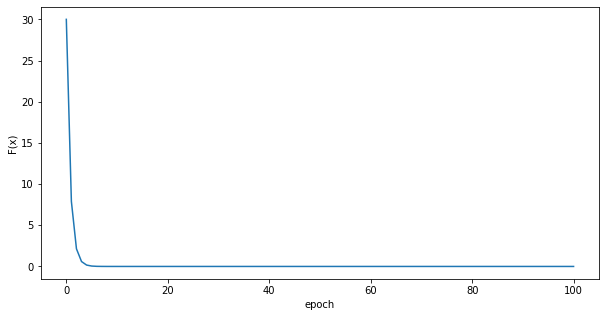

In [4]:
Y = [(p.transpose()@A1@p + p.transpose()@A2@p + p.transpose()@A1@p)/3 for p in points]
plt.figure(figsize=(10, 5))
plt.xlabel('epoch')
plt.ylabel('F(x)')
plt.plot(Y)

Как видим, значение функции со свистом уходит в ноль.  
Попробуем теперь рассмотреть функции вида $f_i(x) = x^T A_i x - b^T x $. Оставим $A_i$ теми же, в качестве $b_i$ возьмем  
$b_1 = (1, 1, 1)^T$ $b_2 = (1, 0, 0)^T$ $b_3 = (0, 0, 0)^T$  
Путем несложных вычислений, которые мы оставляем любознательному читателю в качестве упражнения, получим, что градиент   $F(x) = 2(A_1 + A_2 + A_3)x - b_1 - b_2 - b_3$  
Отсюда $x_* = \frac{1}{2} (A_1 + A_2 + A_3)^{-1}(b_1 + b_2 + b_3)$

In [5]:
b1 = np.array([1, 1, 1])
b2 = np.array([1, 0, 0])
x_min = np.linalg.inv(A1 + A2 + A3)@(b1 + b2)/2
F_min = (x_min.transpose()@A1@x_min + x_min.transpose()@A2@x_min + x_min.transpose()@A3@x_min - b1.transpose()@x_min - b2.transpose()@x_min)/3
print(x_min)
print(F_min)

[0.25       0.08333333 0.1       ]
-0.11388888888888889


Заметим, что L осталось тем же. Посчитаем еще $\sigma_f^2 = \frac{1}{M}\sum \limits_{i = 1}^{M} \|\nabla f_i(x_*)\|^2$.

In [6]:
sigmf = (np.linalg.norm(2*A1@x_min - b1)**2 + np.linalg.norm(2*A2@x_min - b2)**2 + np.linalg.norm(2*A1@x_min)**2)/3
print(sigmf)

0.658888888888889


Отсюда, полагая $x_0 = (10, 5, 13)^T$, найдем $\frac{2\|x_0 - x_*\|^2}{T\gamma} + 24\gamma^2\sigma_f^2H^2L \approx 1.27$

In [7]:
points = ! mpiexec -n 4 python main.py 100 10 '[10, 5, 13]' 0.02 '2*np.array([[1, 0, 0],[0, 2, 0],[0, 0, 3]])@x - np.array([1, 1, 1])' '2*np.array([[1, 0, 0],[0, 2, 0],[0, 0, 1]])@x' '2*np.array([[2, 0, 0],[0, 2, 0],[0, 0, 1]])@x'
points = eval(points[0])

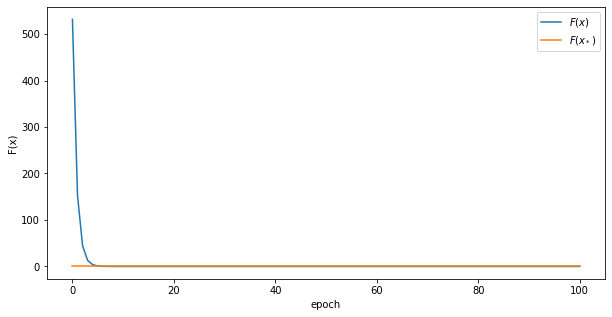

In [8]:
Y1 = [(p.transpose()@A1@p + p.transpose()@A2@p + p.transpose()@A1@p - b1.transpose()@p - b2.transpose()@p)/3 for p in points]
Y2 = [F_min]*len(points)
plt.figure(figsize=(10, 5))
plt.xlabel('epoch')
plt.ylabel('F(x)')
plt.plot(Y1, label='$F(x)$')
plt.plot(Y2, label='$F(x_*)$')
plt.legend()

Чтобы лучше рассмотреть график, откинем первые 15 эпох.

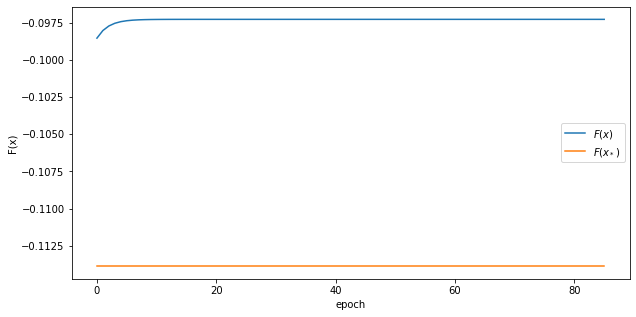

In [9]:
plt.figure(figsize=(10, 5))
plt.xlabel('epoch')
plt.ylabel('F(x)')
plt.plot(Y1[15:], label='$F(x)$')
plt.plot(Y2[15:], label='$F(x_*)$')
plt.legend()

Хотя оптимальное значение и не было достигнуто, ошибка существенно меньше, чем заявленные 1.27, что не может не радовать (стоит отметить, что верхнее ограничение на ошибку давалось, строго говоря, не для стабилизировавшегося значения, а для среднего значения по всем итерациям).